# Env setupu

In [1]:
import pandas as pd
import socket
import os
import yaml
import sys
import statsmodels.api as sm
from scipy import stats
import pyranges as pr
from pyliftover import LiftOver
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pylab as plt
rcParams['figure.figsize'] = 11.7,8.27
import scanpy as sc
from matplotlib import pylab
import anndata as ad
from scipy.spatial import distance
import numpy as np
import scipy.cluster.hierarchy as sch
import itertools

In [2]:
sc.settings.verbosity = 4   

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(facecolor='white')
nprocs=4

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.20.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.12


In [3]:
sc.settings.verbosity = 3  
sc.logging.print_header()
nprocs=4
np.random.seed(0)
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.20.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.12
figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor None
figure.facecolor None
dotSize 20


# Configure paths

In [4]:
outdir = "../data/output"

with open("../data/resources/iPSC_lines_map.yaml", 'r') as f:
    iPSC_lines_map = yaml.load(f, Loader=yaml.FullLoader)["lines"]
colorsmap = dict(zip([i["newName"] for i in iPSC_lines_map.values()],[i["color"] for i in iPSC_lines_map.values()]))


figDir = "./figures"
if not os.path.exists(figDir):
   # Create a new directory because it does not exist
   os.makedirs(figDir)
    
vcfPath = "../data/jointGenotype.g.vcf"

#Path to cellranger gex-GRCh38-2020-A gtf
gtfPath = "../data/resources/genes.gtf"



# Import VCF and Map snps to genes

In [5]:
def get_vcf_names(vcf_path):
    with open(vcf_path, "rt") as ifile:
          for line in ifile:
            if line.startswith("#CHROM"):
                  vcf_names = [x for x in line.split('\t')]
                  break
    ifile.close()
    return vcf_names

names = [i.replace("#","").replace('\n','') for i in get_vcf_names(vcfPath)] 
mappings = {k: v for d in [{k:iPSC_lines_map[k]["newName"]} for k in list(iPSC_lines_map.keys())] for k, v in d.items()}


vcf = pd.read_csv(vcfPath, sep="\t", skip_blank_lines=True,comment='#', names=names).rename(columns = mappings)

MappedVars = vcf.copy()
MappedVars["Chromosome"] = "chr"+vcf["CHROM"].astype(str)
MappedVars["End"] = MappedVars["POS"]
MappedVars["Start"] = MappedVars["POS"]
MappedVars = MappedVars[["Chromosome","Start","End","CHROM"]]
MappedVars = pr.PyRanges(MappedVars)
MappedVars

#Prepare gtf for overlap, we exclude non genes features and keep only coding genes
gtf = pd.read_csv(gtfPath, sep="\t", comment='#', header=None)
gtf = gtf[gtf[2] == "gene"]
gtf['GENE'] = gtf[8].str.extract(r'gene_name "(.+?)";')
gtf['GENEtype'] = gtf[8].str.extract(r'gene_type "(.+?)";')
gtf = gtf[gtf['GENEtype'] == "protein_coding"]
gtf = gtf[[0,3,4,"GENE"]]
gtf.columns = ["Chromosome","Start","End","SYMBOL"]
gtf = pr.PyRanges(gtf)
gtf

MappedVars = MappedVars.join(gtf).df.drop_duplicates(subset=["Chromosome","Start","End"]).drop(columns=["Start_b","End_b"])
MappedVars.index = MappedVars["CHROM"].astype(str)+"_"+MappedVars["Start"].astype(str)
MappedVars["indexer"] = MappedVars.index.tolist()

vcf.index  = vcf["CHROM"].astype(str)+"_"+vcf["POS"].astype(str)
MappedVars["REF"] = vcf.loc[MappedVars.index,"REF"]
MappedVars["ALT"] = vcf.loc[MappedVars.index,"ALT"]

<ipython-input-5-c3aa100863bd>:14: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vcf = pd.read_csv(vcfPath, sep="\t", skip_blank_lines=True,comment='#', names=names).rename(columns = mappings)


# var anndata

In [6]:
varAdata = sc.read_h5ad(outdir+"/adatas/VarAnndata_complete.h5ad")

In [7]:
non_chimeric = varAdata.obs.loc[varAdata.obs["type"] == "non_chimeric","dataset"].unique().tolist()
print(non_chimeric)
chimeric = varAdata.obs.loc[varAdata.obs["type"] == "chimeric","dataset"].unique().tolist()
print(chimeric)


['DownD250', 'DownD100', 'DownD50']
['UpD300', 'UpD100_1', 'UpD100_2', 'UpD50']


# Cleaning VCF from everything > .9 and <.1 AAF to reduce false positive from wrong BulkRNA VC

In [8]:
VCFcolumns = vcf.columns.tolist()[0:9] + [i for i in vcf.columns.tolist()[9:] if i in varAdata.obs.cellID_newName.unique().tolist()]
vcf = vcf[VCFcolumns]

In [9]:

for s in varAdata.obs.cellID_newName.unique().tolist():
    t = vcf[s].str.split(":", expand=True)[[0,1]]
    t = pd.concat([t[0],t[1].str.split(",", expand = True)[[0,1]].astype(int).set_axis(["ref","alt"], axis=1)], axis = 1)
    t["bVal"] = (t["alt"] / (t["ref"]+t["alt"]))
    
    vcf[s] = np.where((t["bVal"] < .9) & (t["bVal"] > .1) & (t[0] == "0/1"), vcf[s], "./.:0,0")
    

In [10]:
vcf

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,CTL01,CTL04E,CTL08A,CTL02A
1_14574,1,14574,rs28503599,A,G,193.46,.,AC=2;AF=0.500;AN=4;BaseQRankSum=-2.638e+00;DB;...,GT:AD:DP:GQ:PL,"0/1:6,8:14:99:156,0,148","./.:0,0","./.:0,0","./.:0,0"
1_14590,1,14590,rs707679,G,A,236.88,.,AC=1;AF=0.250;AN=4;BaseQRankSum=3.92;DB;DP=26;...,GT:AD:DP:GQ:PL,"0/1:9,7:16:99:245,0,357","./.:0,0","./.:0,0","./.:0,0"
1_14599,1,14599,rs707680,T,A,162.88,.,AC=1;AF=0.250;AN=4;BaseQRankSum=2.84;DB;DP=23;...,GT:AD:DP:GQ:PL,"0/1:9,3:12:99:171,0,363","./.:0,0","./.:0,0","./.:0,0"
1_14671,1,14671,rs201055865,G,C,111.26,.,AC=1;AF=0.167;AN=6;BaseQRankSum=-2.255e+00;DB;...,GT:AD:DP:GQ:PL,"./.:0,0","./.:0,0","0/1:10,6:16:99:120,0,329","./.:0,0"
1_16257,1,16257,rs11489794,G,C,77.26,.,AC=1;AF=0.167;AN=6;BaseQRankSum=-2.032e+00;DB;...,GT:AD:DP:GQ:PL,"./.:0,0","./.:0,0","./.:0,0","./.:0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y_56836400,Y,56836400,rs113362920,T,C,271.60,.,AC=1;AF=0.500;AN=2;BaseQRankSum=-2.523e+00;DB;...,GT:AD:DP:GQ:PL,"./.:0,0","./.:0,0","./.:0,0","./.:0,0"
Y_56836412,Y,56836412,rs4893790,A,C,428.03,.,AC=2;AF=1.00;AN=2;DB;DP=14;ExcessHet=3.0103;FS...,GT:AD:DP:GQ:PL,"./.:0,0","./.:0,0","./.:0,0","./.:0,0"
Y_56836676,Y,56836676,rs28671159,C,A,61.60,.,AC=1;AF=0.500;AN=2;BaseQRankSum=0.943;DB;DP=11...,GT:AD:DP:GQ:PL,"./.:0,0","./.:0,0","./.:0,0","./.:0,0"
Y_56875954,Y,56875954,rs9285383,T,A,129.60,.,AC=1;AF=0.500;AN=2;BaseQRankSum=2.67;DB;DP=13;...,GT:AD:DP:GQ:PL,"./.:0,0","./.:0,0","./.:0,0","./.:0,0"


# Ase main function

In [11]:
def aseByObs(adataVar, genoOBS, geno, threshold, fdr,vcf, celltypeOBS, mappedVariants,groupby=None,groups=None ):
    """
    The whole function pivots around celltypes division, that is in our opinion the main covariate that cannot be neglected during ASE exploration
    genoOBS = is the column containing the the second covariate to isolate
    
    geno = is the genotype to isolate the analysis on (if want to do the analysis on several genotypes you have to run 
    multiple times with different geno value)
    the name should be one of the columns of VCF file
    * If your sample contains only 1 genotype you should still use genoOBS, geno arguments (provide mock column with same value)
    * Instead if you want to aggregate from multiple genotype (ignoring genoOBS covariate isolation at your risk) 
    set genoOBS=yourGenoObs and geno=None
    
    threshold = minReads for a locus to be tested
    mappedVariants = secondary DF that contains complementary infos to vcf (rs, gene mappin etc)
    
    """
    
    #First we keep only SNPs mapped to genes    
    vcf = vcf.loc[mappedVariants.index.tolist()]
    
    if type(groups) != list:
        groups = [groups]
        
    if groupby != None:
        _varAdata = varAdata[varAdata.obs[groupby].isin(groups)]
    else:
        _varAdata = varAdata

    if geno != None:        
        hetGeno=vcf.loc[vcf[geno].str.split(":", expand = True)[0] == '0/1',["CHROM","POS"]].astype(str).apply('_'.join, axis=1).tolist()
        print(len(hetGeno))

        # Select for ID, obs and Het loci from bulk
        if groupby != None:
            varAdata_DS_geno = _varAdata[
            ((_varAdata.obs[genoOBS] == geno) & (_varAdata.obs[groupby].isin(groups))),
            list(set(hetGeno).intersection(set(_varAdata.var_names.tolist())))
            ]
        else:
            varAdata_DS_geno = _varAdata[_varAdata.obs[genoOBS] == geno,
            list(set(hetGeno).intersection(set(_varAdata.var_names.tolist())))
            ]
    elif geno == None:
        
        #Aggregate information from all genotypes after checking they are all het at the given locus 
        GenoAdataDict = {}
        for g in _varAdata.obs[genoOBS].unique():

            hetGeno = vcf.loc[vcf[g].str.contains("0/1"),g].index.tolist()
            hetGeno = list(set(hetGeno).intersection(set(_varAdata.var_names.tolist())))

            GenoAdataDict[g] = _varAdata[_varAdata.obs[genoOBS] == g,hetGeno]

        varAdata_DS_geno = ad.concat(list(GenoAdataDict.values()), join="outer")
        del GenoAdataDict
            
            
    
    # isolate ref and Alt reads by leiden    
    # Sum by leiden
    AltReadsDF = pd.DataFrame([pd.Series((varAdata_DS_geno[varAdata_DS_geno.obs[celltypeOBS] == cl].layers["AltReads"].sum(axis = 0).flatten().A1),index=varAdata_DS_geno.var_names) for cl in varAdata_DS_geno.obs[celltypeOBS].unique()], index=varAdata_DS_geno.obs[celltypeOBS].unique()).T
    RefReadsDF = pd.DataFrame([pd.Series((varAdata_DS_geno[varAdata_DS_geno.obs[celltypeOBS] == cl].layers["RefReads"].sum(axis = 0).flatten().A1),index=varAdata_DS_geno.var_names) for cl in varAdata_DS_geno.obs[celltypeOBS].unique()], index=varAdata_DS_geno.obs[celltypeOBS].unique()).T
    TotalDF = AltReadsDF + RefReadsDF
    
    ASEdf = pd.DataFrame()
    
    # Perform cluster-wise thresholding and test 
    for cl in TotalDF.columns:
        MinCountsLoci = TotalDF[TotalDF[cl] > threshold].index.tolist()
        testDF = pd.DataFrame({"AltReads":AltReadsDF.loc[MinCountsLoci,cl], 
                      "RefReads":RefReadsDF.loc[MinCountsLoci, cl]})
        #print(np.array(testDF))

        result = testDF.apply(lambda x: stats.binom_test(
            np.array([x["AltReads"],x["RefReads"]]),
            p=.5),
            axis=1)
                
        if len(result) > 0:
            result = result.to_frame(name="pVal")
            print("Cluster ",cl)
            print("Total tested loci :",testDF.shape[0])
            print("NonCorrected p < 0.05 :",(result["pVal"] < 0.05).sum())

            fdrCorr = sm.stats.multipletests(result["pVal"], method='fdr_bh', alpha=fdr,  is_sorted=False)
            result["Significant"] = fdrCorr[0]
            result["FDR"] = fdrCorr[1]


            print("Corrected FDR < 0.05 :",result["Significant"].sum())
            clDF = result.merge(right=mappedVariants[["SYMBOL","indexer"]], 
                                          left_index=True,right_index=True )
            print("""
            """)
            clDF["celltype"] = cl
            clDF["AltReads"] = AltReadsDF.loc[clDF.index,cl]
            clDF["RefReads"] = RefReadsDF.loc[clDF.index,cl]
            clDF["Prop"] = clDF["AltReads"] / (clDF["AltReads"] + clDF["RefReads"])

            
            ASEdf = pd.concat([ASEdf, clDF], ignore_index=True).sort_values("FDR", ascending = True)
    #print("Tested loci per celltype :",len(ASEdf.indexer.unique()))
    #print("Total significant scored loci across celltypes:",ASEdf.Significant.sum())
    
    return(ASEdf)



    

In [12]:
varAdata.obs.leidenAnnotated.value_counts()

leidenAnnotated
Neurons                       2027
GlutamatergicNeurons_late     1923
RadialGliaProgenitors         1826
ProliferatingProgenitors      1776
GlutamatergicNeurons_early    1475
MigratingNeurons              1271
intermediateProgenitors       1191
Interneurons                  1102
Interneurons_GAD2              994
OuterRadialGliaAstrocytes      693
CajalR_like                    635
Name: count, dtype: int64

# ASE correlation based on bVals - aggregated - 

In [13]:
ASE = aseByObs(varAdata,  genoOBS="cellID_newName", geno=None, celltypeOBS="leidenAnnotated" ,threshold= 20,fdr=0.05 ,vcf=vcf,mappedVariants=MappedVars)


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  GlutamatergicNeurons_late
Total tested loci : 4476
NonCorrected p < 0.05 : 1448
Corrected FDR < 0.05 : 1059

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(


Cluster  Interneurons
Total tested loci : 2151
NonCorrected p < 0.05 : 767
Corrected FDR < 0.05 : 604

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  RadialGliaProgenitors
Total tested loci : 3399
NonCorrected p < 0.05 : 1092
Corrected FDR < 0.05 : 797

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  Interneurons_GAD2
Total tested loci : 2895
NonCorrected p < 0.05 : 1037
Corrected FDR < 0.05 : 761

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  OuterRadialGliaAstrocytes
Total tested loci : 3024
NonCorrected p < 0.05 : 944
Corrected FDR < 0.05 : 666

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  ProliferatingProgenitors
Total tested loci : 4249
NonCorrected p < 0.05 : 1461
Corrected FDR < 0.05 : 1083

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  intermediateProgenitors
Total tested loci : 2900
NonCorrected p < 0.05 : 877
Corrected FDR < 0.05 : 651

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  GlutamatergicNeurons_early
Total tested loci : 2983
NonCorrected p < 0.05 : 1047
Corrected FDR < 0.05 : 779

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  Neurons
Total tested loci : 2563
NonCorrected p < 0.05 : 897
Corrected FDR < 0.05 : 659

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  CajalR_like
Total tested loci : 2499
NonCorrected p < 0.05 : 954
Corrected FDR < 0.05 : 724

            


<ipython-input-11-90e86b95ab1d>:74: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  result = testDF.apply(lambda x: stats.binom_test(
/group/testa/Users/davide.castaldi/organoidMultiplexing_release/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Cluster  MigratingNeurons
Total tested loci : 2704
NonCorrected p < 0.05 : 913
Corrected FDR < 0.05 : 633

            


In [14]:
sns.set_style("ticks")


In [15]:
sc.settings.verbosity = 3  
sc.logging.print_header()
nprocs=4
np.random.seed(0)
with open("../data/resources/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.20.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.13.5 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.12
figure.dpi 80
savefig.dpi 500
figure.figsize [10, 10]
axes.facecolor None
figure.facecolor None
dotSize 20


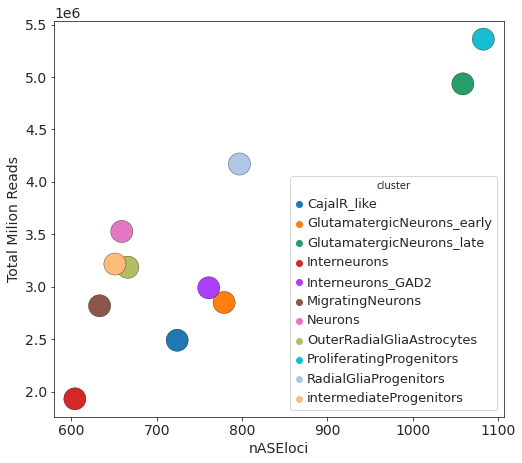

In [16]:
aseByCluster = ASE[ASE.Significant].groupby("celltype").size().to_frame("nASEloci")
cattedSums = []

for cl in varAdata.obs["leidenAnnotated"].unique():
    
    tmpAdata = varAdata[varAdata.obs["leidenAnnotated"] == cl]
    
    SumCounts = tmpAdata.layers["RefReads"] + tmpAdata.layers["AltReads"]
    
    cattedSums.append(SumCounts.data.sum())
    
ReadsByCluster =  pd.DataFrame({"Total Milion Reads":cattedSums},
                               index = varAdata.obs["leidenAnnotated"].unique()
                               )


ase_coverage_ByCluster = pd.concat([aseByCluster,ReadsByCluster], axis = 1)
ase_coverage_ByCluster["cluster"] = ase_coverage_ByCluster.index
ase_coverage_ByCluster


fig, ax = plt.subplots(figsize=(8, 7))

pylab.rcParams['figure.figsize'] = (8, 8)

#sns.regplot(x='nASEloci', y='Total Milion Reads', data=ase_coverage_ByCluster, )
fig = sns.scatterplot(x='nASEloci', y='Total Milion Reads', data=ase_coverage_ByCluster, hue="cluster", s=490,edgecolor='black', linewidth=.3)
fig.get_figure().savefig(figDir+"/ASEgByCoverage.svg")

(874, 11)


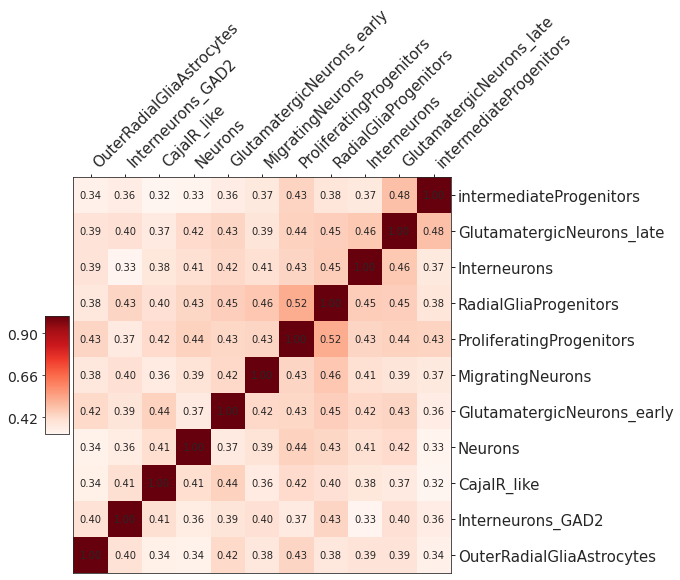

In [17]:
FilteredASE = ASE.copy()

#Keep loci falling into genes expressed in all celltypes
ConservedGenes = FilteredASE.groupby(["indexer","celltype"], as_index=False).size()
ConservedGenes

nCellTypes = len(ConservedGenes.celltype.unique())
ConservedGenes = ConservedGenes.indexer.value_counts()[ConservedGenes.indexer.value_counts() == nCellTypes].index.tolist()

FilteredASE = FilteredASE[FilteredASE.indexer.isin(ConservedGenes)]
FilteredASE

## Correlation on bValues

ASEpivot = pd.DataFrame()
for i in FilteredASE.celltype.unique():
    ctAse = FilteredASE[FilteredASE.celltype == i]
    ctAse.index = ctAse.indexer.tolist()
    ctAse = ctAse["Prop"].to_frame(name=i)
    ASEpivot = pd.concat([ASEpivot,ctAse], axis = 1)
print(ASEpivot.shape)

corr_matrix = ASEpivot.corr(method="spearman")


corr_condensed = distance.squareform(1 - corr_matrix)
z_var = sch.linkage(corr_condensed,method="single")
dendro_info = sch.dendrogram(z_var, labels=list(corr_matrix.index.tolist()), no_plot=True)
clOrder = corr_matrix.iloc[dendro_info["leaves"]].index.tolist()
corr_matrix = corr_matrix.loc[clOrder,clOrder]


fig, ax = plt.subplots(figsize=(8, 7))

cm = ax.pcolormesh(corr_matrix, cmap="Reds",linewidth=.5, vmin=corr_matrix.values.min(), vmax=corr_matrix.values.max())

ax.set_xlim(0, corr_matrix.shape[1])
ax.set_ylim(0, corr_matrix.shape[0])
ax.xaxis.tick_top()
ax.xaxis.set_tick_params(labeltop=True,width=5)
ax.xaxis.set_tick_params(labelbottom=False,width=1)
ax.set_xticks(np.arange(corr_matrix.shape[1]) + 0.5)
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='left',size = 15)

ax.yaxis.tick_right()
ax.yaxis.set_tick_params(width=5)
ax.yaxis.set_tick_params(width=1)
ax.set_yticks(np.arange(corr_matrix.shape[1]) + 0.5)
ax.set_yticklabels(corr_matrix.index,  size = 15)


for row, col in itertools.product(corr_matrix.index.tolist(),
                                  corr_matrix.columns.tolist()):
    ax.text(
        corr_matrix.columns.get_loc(col) + 0.5,
        corr_matrix.index.get_loc(row) + 0.5,
        f"{corr_matrix.loc[row, col]:.2f}",
        ha='center',
        va='center',
        size=10
    )


minV = round(corr_matrix.values.min(),2)
maxV = round(corr_matrix.values.max(),2)
midV = round(maxV - ((maxV - minV) /2),2)
    
fig.colorbar(cm,location='left',shrink=.3 , pad=0.01, aspect=5,ticks=[minV+.1, maxV-.1, midV ])   

fig.show()
fig.savefig(outdir+"/ASEcorr.svg")